# Композиции классификаторов

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Библиотеки

In [2]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from copy import deepcopy
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
from sklearn import tree, base
import itertools
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, BaggingClassifier)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.datasets import make_classification, load_wine, load_boston
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from torchvision import datasets, transforms
import pyfpgrowth
import torch

from mixturelib.mixture import MixtureEM
from mixturelib.local_models import EachModelLinear
from mixturelib.hyper_models import HyperExpertNN, HyperModelDirichlet

## DummyEnsemble

Самый простой вариант ансамблирования это обучение нескольких моделей $b_t\bigr(x\bigr)$ и усреднение ответов:
$$
f\bigr(x\bigr) = \frac{1}{T}\sum_{t=1}^{T}b_t\bigr(x\bigr)
$$
В чем минус данного метода?

In [3]:
class DummyEnsemble(object):
    def __init__(self, base_estimator=None, n_estimators=10):
        self.n_estimators = n_estimators
        self.base_estimator = DecisionTreeClassifier(max_depth=1)
        if base_estimator:
            self.base_estimator = base_estimator
            
        self.b = [base.clone(self.base_estimator) for _ in range(self.n_estimators)]
        
    def get_params(self, deep=True):
        return {'n_estimators': self.n_estimators, 
                'base_estimator': self.base_estimator}
        
    def fit(self, X, Y):
        for b in self.b:
            b.fit(X, Y)
            
    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)
    
    def predict_proba(self, X):
        return np.mean([elem.predict_proba(X) for elem in self.b], axis=0)

In [4]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = DummyEnsemble()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.646 (0.036)


In [5]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = DummyEnsemble(LogisticRegression())

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.800 (0.034)


In [6]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = DummyEnsemble(SVC(probability=True))

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.936 (0.021)


## AdaBoost

Основная идея алгоритма состоит в том, чтобы итеративно дообучать модели на объектах, которые плохо классифицируются предыдущими моделями, при помощи их перевзвешивания.

$$
\sum_{i=1}^{l}\exp\bigr(-y_i\sum_{t=1}^{T}\alpha_tb_t\bigr(x_i\bigr)\bigr)\exp\bigr(-y_i\alpha_Tb_T\bigr(x_i\bigr)\bigr) \to \min_{\alpha_T, b_T}
$$

In [7]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = AdaBoostClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.806 (0.041)


In [8]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = AdaBoostClassifier(SVC(probability=True))

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.931 (0.053)


In [9]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = AdaBoostClassifier(LogisticRegression())

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.794 (0.032)


## Градиентный бустинг

$$
\sum_{i=1}^{l}\mathcal{L}\left(\sum_{t=1}^{T-1}\alpha_tb_t\bigr(x_i\bigr)+\alpha b\bigr(x_i\bigr)\right) \to \min_{\alpha, b}
$$

In [10]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = GradientBoostingClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.888 (0.032)


## Bagging

In [11]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = BaggingClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.847 (0.030)


In [12]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = BaggingClassifier(SVC())

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.935 (0.022)


In [13]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = BaggingClassifier(LogisticRegression())

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.799 (0.039)


## Случайный лес

В данном случае мы говорим о множестве решающих деревьев (отсюда и слово лес).
1. Для задачи классификации в листях деревьев лежит класс.
2. Для задачи регресии в листях лежит среднее значение ответов для всех объектов.

Случайный лес является ансамблем деревьев:
1. Для каждого дерева выбирается произвольное подмножество объектов.
2. Строится каждое дерево не завиимо друг от друга.

In [14]:
data = load_wine()
X = data['data']
Y = data['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=30, 
                                                    random_state=0)

In [15]:
model = RandomForestClassifier(n_estimators=6, max_depth=2, random_state=0)
model.fit(X_train, Y_train)
print(model.score(X_train, Y_train), model.score(X_test, Y_test))
print(classification_report(Y_test, model.predict(X_test)))

0.9797297297297297 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.93      0.97        15
           2       0.86      1.00      0.92         6

    accuracy                           0.97        30
   macro avg       0.95      0.98      0.96        30
weighted avg       0.97      0.97      0.97        30



### Зависимость качества от числа деревьев

In [16]:
models = []
scores_train = []
scores_test = []
n_estimators = list(range(1, 20))
for estimators in n_estimators:
    model = RandomForestClassifier(n_estimators=estimators, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)
    scores_test.append(model.score(X_test, Y_test))
    scores_train.append(model.score(X_train, Y_train))

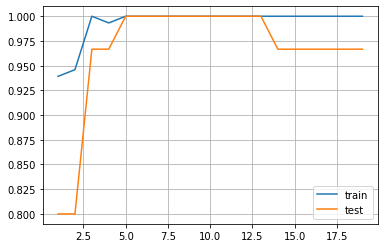

In [17]:
plt.plot(n_estimators, scores_train, label='train')
plt.plot(n_estimators, scores_test, label='test')

plt.legend(loc='best')
plt.grid()
plt.show()

### Зависимость качества от числа признаков при расщеплении

In [18]:
models = []
scores_train = []
scores_test = []
max_features = list(range(1, 13))
for features in max_features:
    model = RandomForestClassifier(n_estimators=6, 
                                   max_features=features, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)
    scores_test.append(model.score(X_test, Y_test))
    scores_train.append(model.score(X_train, Y_train))

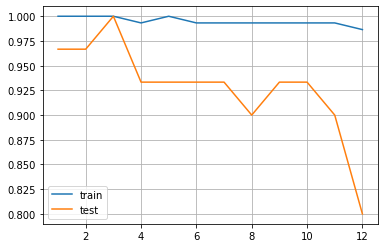

In [19]:
plt.plot(max_features, scores_train, label='train')
plt.plot(max_features, scores_test, label='test')

plt.legend(loc='best')
plt.grid()
plt.show()

### Зависимость качества от глубины деревьев

In [20]:
models = []
scores_train = []
scores_test = []
current_depth = []
max_depth = list(range(1, 10))
for depth in max_depth:
    model = RandomForestClassifier(n_estimators=6,
        max_depth=depth, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)
    scores_test.append(model.score(X_test, Y_test))
    scores_train.append(model.score(X_train, Y_train))
    current_depth.append(model.estimators_[0].get_depth()/depth)

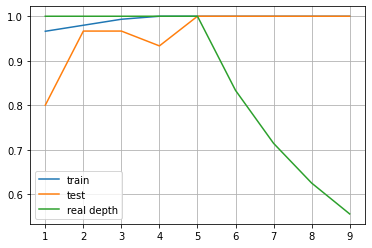

In [21]:
plt.plot(max_depth, scores_train, label='train')
plt.plot(max_depth, scores_test, label='test')
plt.plot(max_depth, current_depth, label='real depth')

plt.legend(loc='best')
plt.grid()
plt.show()

### Замечания по случайному лесу
1. Число деревьев нужно подбирать, так как большое количество деревьев увеличивает качество на обучении, но на валидации, может быть меньше или не меняться вовсе, но время обучении возрастает.
2. Важным параметров является число признаков, которые участвуют в построении правила разделение. Для классификации обычно используется $\sqrt{n}$, а для регрессии $\frac{n}{3}$. Параметр является важным, так как при его увеличении деревья становятся похожими друг на друга.
3. Параметр глубины деревьев можно не подбирать, так как деревья сами настроивают эту высоту. Но если выборка слишком шумная, от рекомендуется не использовать слишком глубокие деревья.

P.S все параметры нужно подбирать на кросс-валидации.

## Mixture of Expert

Смесь экспертов --- мультимодель, определяющая правдоподобие веса $\pi_k$ каждой локальной модели $\textbf{f}_k$ на признаковом описании объекта $\textbf{x}$.

$$
\hat{\mathbf{f}} = \sum_{k=1}^{K}\pi_{k}\mathbf{f}_k, \qquad \pi_{k}\left(\mathbf{x}, \mathbf{V}\right):\mathbb{R}^{n\times \left|\mathbf{V}\right|} \to [0, 1], \qquad \sum_{k=1}^{K}\pi_{k}\left(\mathbf{x}, \mathbf{V}\right) = 1,
$$
где~$\hat{\mathbf{f}}$ --- мультимодель, а $\mathbf{f}_k$ является некоторой моделью, $\pi_k$ --- параметрическая модель, $\mathbf{w}_k$ --- параметры $k$-й локальной модели, $\mathbf{V}$ --- параметры шлюзовой функции.


- Правдоподобие $k$-й локальной модели $p_{k}\left(y_{i}|\mathbf{w}_{k}, \mathbf{x}_{i}\right) = \mathcal{N}\left(y_{i}|\mathbf{w}_{k}^{\mathsf{T}}\mathbf{x}_{i}, \beta^{-1}\right),$
- Априорное распределение параметров $k$-й локальной модели $p^{k}\left(\mathbf{w}_{k}\right) = \mathcal{N}\left(\mathbf{w}_{k}|\mathbf{w}^{0}_{k}, \mathbf{A}_{k}\right),$
- Шлюзовая функция ${\pi}\left(\mathbf{x}, \mathbf{V}\right) = \text{softmax}\bigr(\mathbf{V}_{1}^{\mathsf{T}}{\sigma}\left(\mathbf{V}_2^{\mathsf{T}}\mathbf{x}\right)\bigr).$

$$
p\bigr(\mathbf{y}, \mathbf{W}|\mathbf{X}, \mathbf{V}, \textbf{A}, \textbf{W}^{0}, \beta\bigr) = \prod_{k=1}^{K}\mathcal{N}\left(\mathbf{w}_{k}|\mathbf{w}^{0}_{k}, \mathbf{A}_{k}\right)\prod_{i=1}^{N}\left(\sum_{k=1}^{K}\pi_{k}\mathcal{N}\left(y_{i}|\mathbf{w}_{k}^{\mathsf{T}}\mathbf{x}_{i}, \beta^{-1}\right)\right).
$$

Введем скрытые переменные $\textbf{Z} = ||z_{ik}||,$ где $~z_{ik} = 1 \Leftrightarrow k_i=k$:
$$
p\bigr(\mathbf{y}, \textbf{Z}, \mathbf{W}|\mathbf{X}, \mathbf{V}, \textbf{A}, \textbf{W}^{0}, \beta\bigr) = \prod_{k=1}^{K}\mathcal{N}\left(\mathbf{w}_{k}|\mathbf{w}^{0}_{k}, \mathbf{A}_{k}\right)\prod_{i=1}^{N}\prod_{k=1}^{K}\left(\pi_{k}\mathcal{N}\left(y_{i}|\mathbf{w}_{k}^{\mathsf{T}}\mathbf{x}_{i}, \beta^{-1}\right)\right)^{z_{ik}}.
$$

Вариационный ЕМ--алгоритм $q\left(\textbf{Z}, \textbf{W}\right) = q\left(\textbf{Z}\right)q\left(\textbf{W}\right)$:

- E-шаг:
$$
\log q\left(\textbf{Z}^{s}\right) \propto \mathsf{E}_{q/\textbf{Z}}\log p\bigr(\mathbf{y}, \textbf{Z},\mathbf{W}|\mathbf{X}, \mathbf{V}^{s-1}, \textbf{A}^{s-1}, \textbf{W}^{0, s-1}, \beta^{s-1}\bigr)
$$
$$\log q\left(\textbf{W}^{s}\right) \propto \mathsf{E}_{q/\textbf{W}}\log p\bigr(\mathbf{y}, \textbf{Z},\mathbf{W}|\mathbf{X}, \mathbf{V}^{s-1}, \textbf{A}^{s-1}, \textbf{W}^{0, s-1}, \beta^{s-1}\bigr)
$$
- M-шаг:
$$
\textbf{W}^{0, s}, \textbf{A}^{s}, \beta^{s} = \arg\max_{\textbf{W}^{0}, \textbf{A}, \beta} \mathbf{E}_{q^{s}}\log p\bigr(\mathbf{y}, \textbf{Z},\mathbf{W}|\mathbf{X}, \mathbf{V}, \textbf{A}, \textbf{W}^{0}, \beta\bigr)
$$

Итерационные формулы ЕМ-алгоритма:

- E-шаг:
$$
p\left(z_{ik} = 1\right) = \frac{\exp\left(\log\pi_{k}\left(\textbf{x}_{i}, \textbf{V}\right) - \frac{\beta}{2}\left(\textbf{x}_{i}^{\mathsf{T}}\mathsf{E}\textbf{w}_{k}\textbf{w}_{k}^{\mathsf{T}}\textbf{x}_{i} - \textbf{x}_{i}^{\mathsf{T}}\mathsf{E}\textbf{w}_{k}\right)\right)}{\sum_{k'=1}^{K}\exp\left(\log\pi_{k'}\left(\textbf{x}_{i}, \textbf{V}\right) - \frac{\beta}{2}\left(\textbf{x}_{i}^{\mathsf{T}}\mathsf{E}\textbf{w}_{k'}\textbf{w}_{k'}^{\mathsf{T}}\textbf{x}_{i} - \textbf{x}_{i}^{\mathsf{T}}\mathsf{E}\textbf{w}_{k'}\right) \right)},
$$
$$
q(\textbf{w}_k) = \mathcal{N}(\textbf{w}_k|\textbf{m}_k, \textbf{B}_k),
$$
$$
\mathbf{m}_{k} = \mathbf{B}_{k}\left(\mathbf{A}_{k}^{-1}\mathbf{w}_{k}^{0}+\beta\sum_{i=1}^{N}\mathbf{x}_{i}y_{i}\mathsf{E}z_{ik}\right), \quad \mathbf{B}_{k} = \left(\mathbf{A}_{k}^{-1}+\beta\sum_{i=1}^{N}\mathbf{x}_{i}\mathbf{x}_{i}^{\mathsf{T}}\mathsf{E}z_{ik}\right)^{-1} .
$$

- M-шаг:
$$
\textbf{A}_{k} = \mathsf{E}\textbf{w}_{k}\textbf{w}_{k}^{\mathsf{T}} - \textbf{w}_{k}^{0}\mathsf{E}\textbf{w}_{k}^{\mathsf{T}} - \mathsf{E}\textbf{w}_{k}\textbf{w}_{k}^{0\mathsf{T}} + \textbf{w}_{k}^{0}\textbf{w}_{k}^{0\mathsf{T}},
$$
$$
\frac{1}{\beta}=\frac{1}{N}\sum_{i=1}^{N}\sum_{k=1}^{K}\left[y_{i}^{2}-2y_{i}\textbf{x}_{i}^{\mathsf{T}}\mathsf{E}\textbf{w}_{k} + \textbf{x}_{i}^{\mathsf{T}}\mathsf{E}\textbf{w}_{k}\textbf{w}_{k}^{\mathsf{T}}\textbf{x}_{i}\right]\mathsf{E}z_{ik},
$$
$$
\textbf{w}_{k}^{0} =\mathsf{E}\textbf{w}_{k},
$$
$$
\textbf{V}= \arg\max_{\textbf{V}} \mathbf{E}_{q^{s}}\log p\bigr(\mathbf{y}, \textbf{Z},\mathbf{W}|\mathbf{X}, \mathbf{V}, \textbf{A}, \textbf{W}^{0}, \beta\bigr).
$$

In [22]:
np.random.seed(42)

N = 200
noise_component = 0.8
noise_target = 5

X = np.random.randn(N, 2)
X[:N//2, 1] *= noise_component
X[N//2:, 0] *= noise_component

real_first_w = np.array([[10.], [0.]])
real_second_w = np.array([[0.], [30.]])

y = np.vstack([X[:N//2]@real_first_w, X[N//2:]@real_second_w])\
    + noise_target*np.random.randn(N, 1)

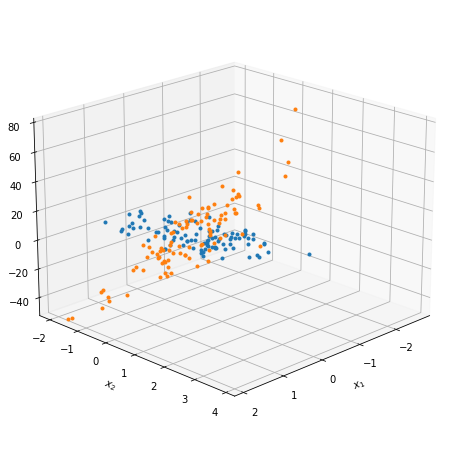

In [23]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:N//2, 0], X[:N//2,1], y[:N//2, 0], '.')
ax.plot(X[N//2:, 0], X[N//2:,1], y[N//2:, 0], '.')

ax.set_zlim((-50, 80))
ax.view_init(20, 45)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

In [24]:
X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(y)

In [25]:
torch.random.manual_seed(42)
first_model = EachModelLinear(input_dim=2)
secode_model = EachModelLinear(input_dim=2)

list_of_models = [first_model, secode_model]

In [26]:
HpMd = HyperExpertNN(input_dim=2, hidden_dim=5,
                     output_dim=2, epochs=100)

In [27]:
mixture = MixtureEM(HyperParameters={'beta': 1.},
                    HyperModel=HpMd,
                    ListOfModels=list_of_models,
                    model_type='sample')

In [28]:
mixture.fit(X_tr, Y_tr, epoch=100)

In [29]:
predicted_first_w = mixture.ListOfModels[1].W.numpy()
predicted_second_w = mixture.ListOfModels[0].W.numpy()

In [30]:
def plot_result():
    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_subplot(111, projection='3d')

    grid_2d = np.array(np.meshgrid(range(-5, 5), range(-5, 5)))
    xx, yy = grid_2d

    first_z = (predicted_first_w.reshape([-1, 1, 1])*grid_2d).sum(axis=0)
    second_z = (predicted_second_w.reshape([-1, 1, 1])*grid_2d).sum(axis=0)
    ax.plot_surface(xx, yy, first_z, alpha = 0.25, color = 'red', label='predicted')
    ax.plot_surface(xx, yy, second_z, alpha = 0.25, color = 'blue', label='predicted')

    first_z = (real_first_w.reshape([-1, 1, 1])*grid_2d).sum(axis=0)
    second_z = (real_second_w.reshape([-1, 1, 1])*grid_2d).sum(axis=0)
    ax.plot_wireframe(xx, yy, first_z, linewidth=1, color = 'red')
    ax.plot_wireframe(xx, yy, second_z, linewidth=1, color = 'blue')

    ax.view_init(20, 170)

    ax.set_xlabel('$x_1$', fontsize=15, fontweight="bold")
    ax.set_ylabel('$x_2$', fontsize=15, fontweight="bold")
    ax.set_zlabel('$y$', fontsize=15, fontweight="bold")

    plt.show()

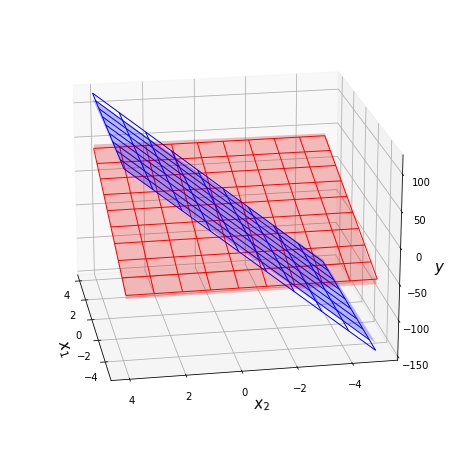

In [31]:
plot_result()